# News Sentiment Analysis

## Import Libraries

In [1]:
# // TODO: TINGS
#     ✓ Find API for data collection
#     ✓ Data Gathering
#     ✓ Data Cleaning
#     - Feature generation
#     - Feature Engineering/selection
#     - Model Train
#     - Model Test
#     - Model Evaluation

In [2]:
# Common Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import glob
import re
from IPython.display import clear_output
import time
import random

# Cleaner output
from tqdm import tqdm

# Deep Learning Libraries
import torch

# Add the path to the API Scraper
## Project Path
project_path = "../"

## Add the path to API Scraper
sys.path.append(os.path.abspath(os.path.join(project_path, "lib")))

# Custom News Libraries
from scraper import get_cached_news_metadata, extract_text_from_url

# Text preprocessing
from preprocessor import clean_text

## Fetch Data

In [3]:
def scrape_data(n_request: int = 10, before_date: str = "2025-12", path: str = ".", last_idx:int = 0) -> pd.DataFrame:
    
    articles = []

    for i in tqdm(range(last_idx, last_idx + n_request), desc="Fetching News Data...", unit="news"):
        metadata = get_cached_news_metadata(page=i, before_date=before_date, path=path)

        data_list = metadata.get("data", [])

        for article in data_list:
            # extract sentiment (first entity if exists)
            entities = article.get("entities", [])
            if entities and "sentiment_score" in entities[0]:
                sentiment = entities[0]["sentiment_score"]
            else:
                sentiment = None

            # store sentiment as its own field inside article
            article["sentiment"] = sentiment

            articles.append(article)

    # final dataframe
    return pd.DataFrame(articles)

### Caching

In [ ]:
# Arguments for the caching function
before_date = "2025-11"

data_path = os.path.join(project_path,f"news_cache/{before_date}/csv/")
os.makedirs(data_path, exist_ok=True) # if the directory exist no need to make

cached_file = os.path.join(data_path, f"{before_date}_news_data.csv")

# Set this to TRUE if you want to get new data/overwrite the old data
overwrite_cached_links = True

# get the last index of the file 
json_files = os.path.join(project_path, f"news_cache/{before_date}/json/page-*.json")
list_of_files = glob.glob(json_files)

## Extract page numbers set to True if you want to get new api request.
get_new_requests = True

if get_new_requests:
    page_nums = []
    for f in list_of_files:
        match = re.search(r"page-(\d+)\.json$", os.path.basename(f))
        if match:
            page_nums.append(int(match.group(1)))

    last_idx = max(page_nums)
    n_requests = 101 # marketaux api limit (last index is excluded)

else:
    last_idx = 0
    n_requests = len(list_of_files) #number of pages we cached to be processed

In [6]:
# filling missing text data function

def safe_extract(row):
    try:
        text = extract_text_from_url(row["url"])
        # print(f"{row['title']} {row['description']}")
        return text

    except Exception as e:
        tqdm.write(f"failed to extract from url \n Err: {e} \n appending title and description")
        time.sleep(2)
        print(f"{row['title']} {row['description']}")
        clear_output(wait=True)
        text = f"{row['title']} {row['description']}"
        return text

In [7]:
# tqdm for cleaner output
tqdm.pandas(desc="Extracting News from URL's", unit="news")

# We will cache the data so that it will load faster
if os.path.exists(cached_file) and not overwrite_cached_links:
    print("Loading cached dataset...")
    news_df = pd.read_csv(cached_file, sep = ',')
    print("Cached dataset loaded")

elif os.path.exists(cached_file) and overwrite_cached_links:
    print("Overwriting old data and caching new data...")
    # Scrape the data
    news_df = scrape_data(n_request=n_requests, before_date= before_date, path= project_path, last_idx=last_idx)
    
    # Extract text from the news
    news_df["text"] = news_df.progress_apply(safe_extract, axis=1)
    news_df.to_csv(cached_file, index=False)
    print("Done Overwriting old data and caching new data...")

else:
    print("Creating and caching dataset...")
    news_df = scrape_data(n_request=n_requests, before_date= before_date, path= project_path, last_idx=last_idx)
    news_df["text"] = news_df.progress_apply(safe_extract, axis=1)
    news_df.to_csv(cached_file, index=False)
    print("Finished Caching")

Overwriting old data and caching new data...


Fetching News Data...:  75%|███████▌  | 75/100 [11:29<03:49,  9.19s/news]


ConnectionError: HTTPSConnectionPool(host='api.marketaux.com', port=443): Max retries exceeded with url: /v1/news/all?api_token=uM0txqVQtjsgbj4RR66PAcne4QxoxuPbSvAdriEc&published_before=2025-11&page=3568&sentiment_lte=1&language=en (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7892e6445110>: Failed to establish a new connection: [Errno 101] Network is unreachable'))

### Fetch the Text from URL

## EDA

### View the Data

In [8]:
news_df.head(10)

,uuid,title,description,keywords,snippet,url,image_url,language,published_at,source,relevance_score,entities,similar,sentiment,text
0,17316eef-cc55-4bad-b661-a3062a43c4f5,Barton Gold Completes $15m Franklin Templeton-...,Barton Gold (ASX: BGD) (OTCQB: BGDFF) has rece...,,Barton Gold (ASX: BGD) (OTCQB: BGDFF) has rece...,https://smallcaps.com.au/barton-gold-franklin-...,https://smallcapsau.mystagingwebsite.com/wp-co...,en,2025-10-22T00:37:03.000000Z,smallcaps.com.au,None,"[{'symbol': 'CGF.AX', 'name': 'Challenger Limi...",[],0.690800,Barton Gold (ASX: BGD) (OTCQB: BGDFF) has rece...
1,e35d5ef0-4300-4dbe-8d13-52df7f56ecce,CF Energy Confirms Availability of Meeting Mat...,"TORONTO, Oct. 21, 2025 (GLOBE NEWSWIRE) -- CF ...","CF, Energy, Confirms, Availability, of, Meetin...","TORONTO, Oct. 21, 2025 (GLOBE NEWSWIRE) -- CF ...",https://www.manilatimes.net/2025/10/22/tmt-new...,https://www.manilatimes.net/manilatimes/upload...,en,2025-10-22T00:36:54.000000Z,manilatimes.net,None,"[{'symbol': 'CGFEF', 'name': 'CF Energy Corp.'...",[{'uuid': 'fb79fb0d-71f9-48e2-9944-de450443ef4...,0.535240,
2,f57835ab-1b98-4136-8c93-eee79f1361b8,Netflix outlines ad revenue doubling in 2025 a...,Discover Netflix's Q3 2025 earnings insights: ...,,"To ensure this doesn’t happen in the future, p...",https://seekingalpha.com/news/4506448-netflix-...,https://static.seekingalpha.com/assets/og_imag...,en,2025-10-22T00:35:15.000000Z,seekingalpha.com,None,"[{'symbol': 'NFLX', 'name': 'Netflix, Inc.', '...",[],0.458800,"To ensure this doesnât happen in the future,..."
3,dc078713-7761-4c60-b5c4-161319434075,PennyMac Mortgage Investment Trust (PMT) Q3 20...,PennyMac Mortgage Investment Trust (NYSE:PMT) ...,,Presentation\n\nOperator\n\nGood afternoon and...,https://seekingalpha.com/article/4831658-penny...,https://static.seekingalpha.com/assets/og_imag...,en,2025-10-22T00:24:32.000000Z,seekingalpha.com,None,"[{'symbol': 'PMT', 'name': 'PennyMac Mortgage ...",[{'uuid': '75490db0-c500-4123-9cc4-ab1857a92ff...,0.000000,Presentation\n\nOperator\n\nGood afternoon and...
4,ab601781-0206-43c8-89db-0e55c201da0c,2 Rock-Solid Dividend Stocks With Room to Grow,These companies pay very durable and steadily ...,"Chevron, Dividend stocks, Coca-Cola, dividend ...",Key Points\n\nCoca-Cola has increased its divi...,https://finance.yahoo.com/news/2-rock-solid-di...,https://s.yimg.com/ny/api/res/1.2/cwFsF0xfApXM...,en,2025-10-22T00:24:00.000000Z,finance.yahoo.com,None,"[{'symbol': 'CVX', 'name': 'Chevron Corporatio...",[],0.585720,Key Points\n\nCoca-Cola has increased its divi...
5,4bee7508-28c2-4675-b56f-250520a12348,Goldman basket shows painful month for shorts,US stocks are seeing aggressive buying as shor...,"Goldman Sachs, short-sellers, S&P 500, stock m...",Bloomberg\n\nLive Events\n\nAgencies\n\n\n\nas...,https://economictimes.indiatimes.com/markets/s...,"https://img.etimg.com/thumb/msid-124731428,wid...",en,2025-10-22T00:23:11.000000Z,economictimes.indiatimes.com,None,"[{'symbol': 'PTON', 'name': 'Peloton Interacti...",[],0.771700,Synopsis\n\nUS stocks are seeing aggressive bu...
6,427f69a8-adf5-4383-b034-7707ca3abedf,Eli Lilly and Company (LLY): A Bull Case Theory,We came across a bullish thesis on Eli Lilly a...,,Artificial intelligence is the greatest invest...,https://www.insidermonkey.com/blog/eli-lilly-a...,https://d2gr5kl7dt2z3t.cloudfront.net/blog/wp-...,en,2025-10-22T00:19:38.000000Z,insidermonkey.com,None,"[{'symbol': 'LLY', 'name': 'Eli Lilly and Comp...",[{'uuid': '427f69a8-adf5-4383-b034-7707ca3abed...,0.000000,Artificial intelligence is the greatest invest...
7,d60e211c-98a4-4ecc-ae5f-ae4607036870,"Axon Enterprise, Inc. (AXON): A Bull Case Theory",We came across a bullish thesis on Axon Enterp...,,Artificial intelligence is the greatest invest...,https://www.insidermonkey.com/blog/axon-enterp...,https://d2gr5kl7dt2z3t.cloudfront.net/blog/wp-...,en,2025-10-22T00:19:28.000000Z,insidermonkey.com,None,"[{'symbol': 'AXON', 'name': 'Axon Enterprise, ...",[],0.000000,A

### Check for Missing Values

In [9]:
is_na = pd.DataFrame(news_df.isna().sum())
is_na.columns = ["Number_Missing"]
is_na["Missing_Percentage"] = (is_na["Number_Missing"] / len(news_df) * 100)
print(is_na)

                 Number_Missing  Missing_Percentage
uuid                          0                 0.0
title                         0                 0.0
description                   0                 0.0
keywords                      0                 0.0
snippet                       0                 0.0
url                           0                 0.0
image_url                     0                 0.0
language                      0                 0.0
published_at                  0                 0.0
source                        0                 0.0
relevance_score             303               100.0
entities                      0                 0.0
similar                       0                 0.0
sentiment                     0                 0.0
text                          0                 0.0


### Distribution of the Sentiment Scores

#### Plotting Functions

In [10]:
#setting the colors generator
def fill_color_generator():
    """This generates a color

    Returns:
        color: An R,G,B value with a range of 0 to 1
    """
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return (r/255, g/255, b/255)

#function for plotting numerical data distribution
def numeric_dist_plot(data: pd.DataFrame):
    """This function creates a plot of the distribution of the numerical data. 

    Args:
        data (pd.DataFrame): Numeric pandas dataframe

    Raises:
        TypeError: The following columns are not numeric: {non_numeric_cols}
        This is due to some of the columns are not numeric.

    Returns:
        Displays a plot of
    """
    # Checks
    ## Check if all columns are numeric
    non_numeric_cols = [col for col in data.columns if not pd.api.types.is_numeric_dtype(data[col])]
    if non_numeric_cols:
        raise TypeError(f"The following columns are not numeric: {non_numeric_cols}")
    
    # Plotting the numerical data
    #titles for plots/figures
    fig_titles = []

    for colName in data.columns:
        fig_titles.append(f"Boxplot Of {colName}")
        fig_titles.append(f"Histogram Of {colName}")
        
    fill_color_dict = {}
    for colName in data.columns:
        fill_color_dict[colName] = fill_color_generator()

    # make subplot for each column name
    num_rows = len(data.columns)
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, num_rows * 3))

    # Flatten axes for easier indexing when there's more than 1 row
    axes = axes if num_rows > 1 else [axes]

    for i, column in enumerate(data.columns):
        color = fill_color_dict[column]

        # Boxplot
        axes[i][0].boxplot(data[column].dropna(), vert=False, patch_artist=True,
                        boxprops=dict(facecolor=color, color=color),
                        medianprops=dict(color="black"))
        axes[i][0].set_title(f"Boxplot of {column}")
        axes[i][0].set_xlabel(column)

        # Histogram
        axes[i][1].hist(data[column].dropna(), bins=20, color=color, alpha=0.7, edgecolor='black')
        axes[i][1].set_title(f"Histogram of {column}")
        axes[i][1].set_xlabel(column)

    # Overall layout
    fig.suptitle("Boxplot and Distribution Visualization", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit title
    return plt

#### Data Plots (Before Cleaning)

##### Sentiment Score Distribution

<module 'matplotlib.pyplot' from '/home/andrew/miniconda3/envs/text_mining_research-env/lib/python3.11/site-packages/matplotlib/pyplot.py'>

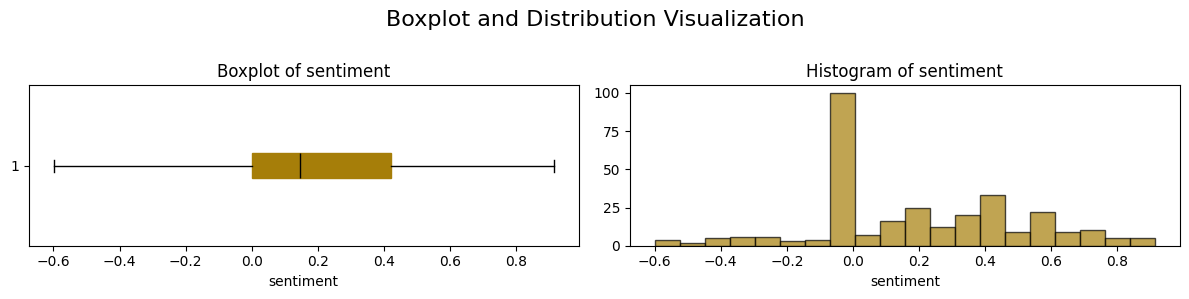

In [11]:
numeric_dist_plot(pd.DataFrame(news_df["sentiment"]))

##### Word Count Distribution

<Axes: title={'center': 'Text_Length Distribution'}, xlabel='length', ylabel='Count'>

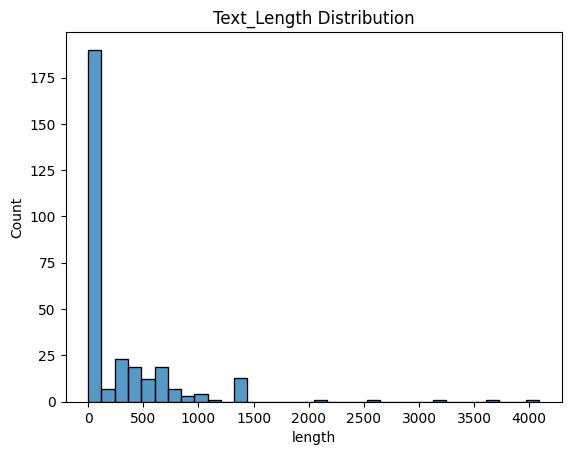

In [12]:
news_df['text'] = news_df['text'].apply(str)
news_df['length'] = news_df['text'].str.split().apply(len)
plt.title("Text_Length Distribution")
sns.histplot(news_df['length'])

In [13]:
news_df['length'].describe()

count     303.000000
mean      287.237624
std       524.894461
min         0.000000
25%         0.000000
50%        38.000000
75%       409.000000
max      4089.000000
Name: length, dtype: float64

## Data Cleaning

### Fix Missing Values

In [14]:
news_df["text"] = news_df["text"].replace("", None)

In [15]:
is_na = pd.DataFrame(news_df.isna().sum())
is_na.columns = ["Number_Missing"]
is_na["Missing_Percentage"] = (is_na["Number_Missing"] / len(news_df) * 100)
print(is_na)

                 Number_Missing  Missing_Percentage
uuid                          0            0.000000
title                         0            0.000000
description                   0            0.000000
keywords                      0            0.000000
snippet                       0            0.000000
url                           0            0.000000
image_url                     0            0.000000
language                      0            0.000000
published_at                  0            0.000000
source                        0            0.000000
relevance_score             303          100.000000
entities                      0            0.000000
similar                       0            0.000000
sentiment                     0            0.000000
text                        128           42.244224
length                        0            0.000000


In [16]:
news_df["description"] = news_df["description"].fillna('')

#Fill the missing text from the url with just the news description. due to the scraper is unable to get the html since the site requires authorization
news_df["text"] = news_df["text"].fillna(
    news_df["title"].fillna('') + " " + news_df["description"].fillna('')
)

In [17]:
is_na = pd.DataFrame(news_df.isna().sum())
is_na.columns = ["Number_Missing"]
is_na["Missing_Percentage"] = (is_na["Number_Missing"] / len(news_df) * 100)
print(is_na)

                 Number_Missing  Missing_Percentage
uuid                          0                 0.0
title                         0                 0.0
description                   0                 0.0
keywords                      0                 0.0
snippet                       0                 0.0
url                           0                 0.0
image_url                     0                 0.0
language                      0                 0.0
published_at                  0                 0.0
source                        0                 0.0
relevance_score             303               100.0
entities                      0                 0.0
similar                       0                 0.0
sentiment                     0                 0.0
text                          0                 0.0
length                        0                 0.0


### Drop Duplicated Data

In [18]:
news_df.duplicated().sum()

TypeError: unhashable type: 'list'

In [ ]:
news_df = news_df.drop_duplicates()

In [ ]:
news_df.duplicated().sum()

np.int64(0)

### Clean the Text

In [ ]:
# Arguments for the caching function
cleaned_data_path = os.path.join(project_path,f"news_cache/{before_date}/csv/")
os.makedirs(cleaned_data_path, exist_ok=True) # if the directory exist no need to make

clean_cached_file = os.path.join(cleaned_data_path, f"{before_date}_clean_news_data.csv")

# Set this to TRUE if you want to get new data/overwrite the old data
overwrite_clean_data = False

In [ ]:
# tqdm for cleaner output
tqdm.pandas(desc="Cleaning the Text", unit="news")

# We will cache the data so that it will load faster
if os.path.exists(clean_cached_file) and not overwrite_clean_data:
    print("Loading cached dataset...")
    news_df = pd.read_csv(clean_cached_file)
    print("Cached dataset loaded")

elif os.path.exists(clean_cached_file) and overwrite_clean_data:
    print("Overwriting old data and caching new data...")
    # Clean the data
    news_df["clean_text"] = news_df["text"].progress_apply(
                                                        lambda x: clean_text(
                                                            text = x,
                                                            tokenize=False,
                                                            remove_stop_words= True,
                                                            remove_emojis="keep"
                                                            )
                                                        )
    news_df.to_csv(clean_cached_file, index=False)
    print("Done Overwriting old data and caching new data...")

else:
    print("Creating and caching dataset...")
    # Clean the data
    news_df["clean_text"] = news_df["text"].progress_apply(
                                                        lambda x: clean_text(
                                                            text = x,
                                                            tokenize=False,
                                                            remove_stop_words= True,
                                                            remove_emojis="keep"
                                                            )
                                                        )
    news_df.to_csv(clean_cached_file, index=False)
    print("Finished Caching")

Loading cached dataset...
Cached dataset loaded


In [ ]:
is_na = pd.DataFrame(news_df.isna().sum())
is_na.columns = ["Number_Missing"]
is_na["Missing_Percentage"] = (is_na["Number_Missing"] / len(news_df) * 100)
print(is_na)

                 Number_Missing  Missing_Percentage
uuid                          0            0.000000
title                         0            0.000000
description                 414            4.566009
keywords                   4774           52.652476
snippet                      37            0.408073
url                           0            0.000000
image_url                    36            0.397044
language                      0            0.000000
published_at                  0            0.000000
source                        0            0.000000
relevance_score            9067          100.000000
entities                      0            0.000000
similar                       0            0.000000
sentiment                     0            0.000000
text                          0            0.000000
length                        0            0.000000
clean_text                    0            0.000000


##### Sentiment Score Distribution (After Cleaning)

<module 'matplotlib.pyplot' from '/home/andrew/miniconda3/envs/text_mining_research-env/lib/python3.11/site-packages/matplotlib/pyplot.py'>

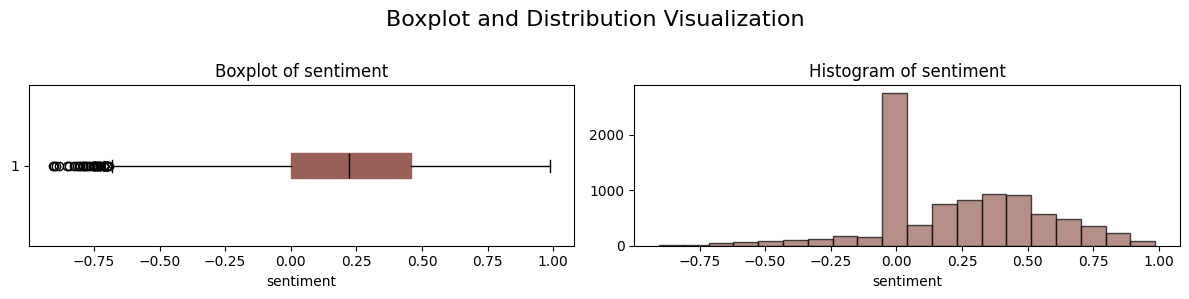

In [ ]:
numeric_dist_plot(pd.DataFrame(news_df["sentiment"]))

##### Word Count Distribution

<Axes: title={'center': 'Text_Length Distribution'}, xlabel='length', ylabel='Count'>

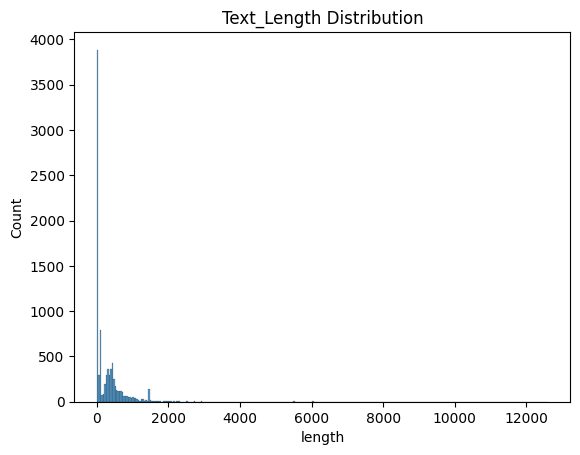

In [ ]:
news_df['text'] = news_df['text'].apply(str)
news_df['length'] = news_df['text'].str.split().apply(len)
plt.title("Text_Length Distribution")
sns.histplot(news_df['length'])

In [ ]:
news_df['length'].describe()

count     9067.000000
mean       340.722510
std        789.960782
min          1.000000
25%          1.000000
50%         89.000000
75%        428.000000
max      12606.000000
Name: length, dtype: float64